## Description

In this notebook, we compare the outcomes of different approaches to annotation of spectra of lipids in the context of MS imaging:  
  - Accurate mass matching in the average spectrum (a commonly used approach)
  - Matching theoretical spectra to the average spectrum using `masserstein` 
  - Deconvolving each pixel independently with `masserstein`  
  
We use a custom set of lipid formulas downloaded from LIPID MAPS data base. The set of lipids is supplied with the notebook.  

## Data & modules

In [24]:
%matplotlib notebook

In [25]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
from venn import venn
from additional_functions import profile_ion_image, centroided_ion_image

In [26]:
import numpy.random as rd

In [27]:
analyzed_mass_range = (600, 1000)

Load the centroided MS images calculated in Notebook 2:

In [28]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [29]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [30]:
images = [cerebellum_centroided_image, bladder_centroided_image]
shapes = [cerebellum_image_shape, bladder_image_shape]
names = ['cerebellum', 'bladder']

In [31]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

In [32]:
raw_images = [cerebellum_profile_image, bladder_profile_image]

Load the average spectra calculated in Notebook 2:

In [33]:
average_spectra = []
average_spectrum_masses = []
for i, n in enumerate(names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra.append(sp)
    average_spectrum_masses.append([x[0] for x in sp.confs])

<IPython.core.display.Javascript object>


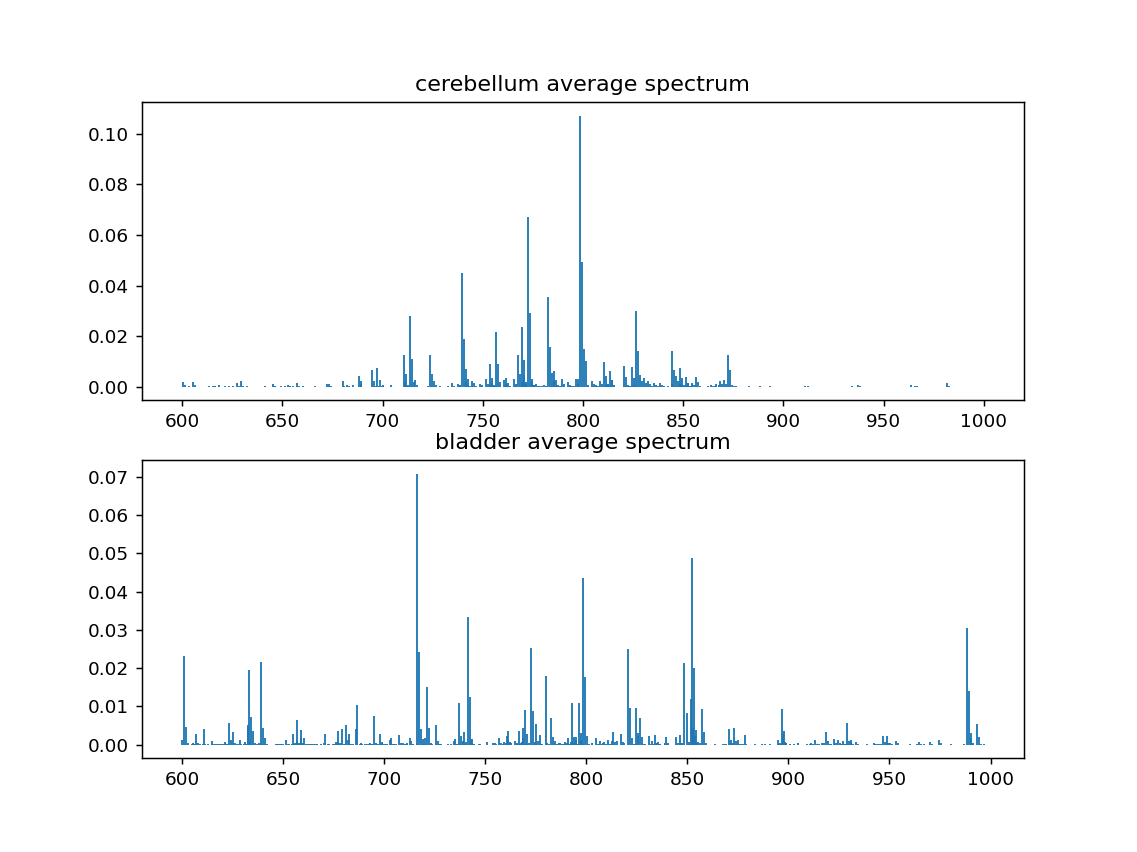

In [34]:
plt.figure()
for i, n in enumerate(names):
    plt.subplot(211+i)
    plt.title(n + ' average spectrum')
    average_spectra[i].plot()

Load the lipid formulas:

In [35]:
lipid_formulas = []
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        l = l[3] 
        if set(l).issubset(set('CHNOP0123456789')):
            lipid_formulas.append(l)
lipid_formulas = list(set(lipid_formulas))
print('Loaded %i lipid formulas' % len(lipid_formulas))


Loaded 4143 lipid formulas


Generate the lipid reference spectra (assuming a potassium adduct). We'll take the peaks that are at least 5% as high as the highest one.  

In [36]:
lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in lipid_formulas]
for s in lipid_spectra: 
    s.normalize()

We'll discard the spectra that are outside of our desired mass range

In [37]:
lipid_spectra = [s for s in lipid_spectra if analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]]
print('Retained %i lipid spectra' % len(lipid_spectra))

Retained 2218 lipid spectra


Get the monoisotopic masses of our lipid ions:

In [38]:
lipid_masses = [s.confs[0][0] for s in lipid_spectra]

Get the positive control lipid spectra (we'll use them to check the deconvolution results)

In [39]:
control_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
control_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
control_lipid_spectrum_ids = [i for i,s in enumerate(lipid_spectra) if s.formula in control_lipid_formulas]
assert len(control_lipid_spectrum_ids) == 3

Example theoretical spectrum:

<IPython.core.display.Javascript object>


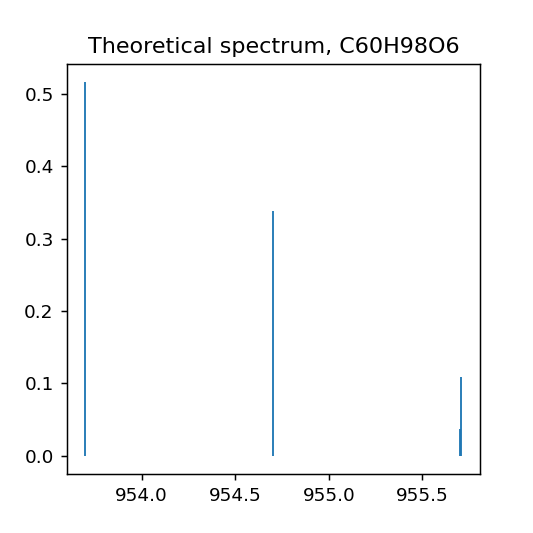

In [40]:
plt.figure(figsize=(4,4))
i = 1000
plt.title('Theoretical spectrum, %s' % lipid_spectra[i].formula)
lipid_spectra[i].plot()
plt.show()

## Mass matching accuracy settings

In [41]:
ppm_threshold = 100
MTD = 0.005
MTD_th = 0.01

## Masserstein deconvolution of the average spectrum

In [42]:
proportions_in_average = []
regression_times = []
for i, sp in enumerate(average_spectra):
    s = time()
    regression = estimate_proportions(sp, lipid_spectra, MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1)
    e = time()
    proportions_in_average.append(regression['proportions'])
    regression_times.append(e-s)
print('Regression times:')
for n,t in zip(names, regression_times):
    print(n, round(t, 2), 'seconds')

Computing chunks: 100%|█████████████████████████████████████████████████████████████████████████████| 2218/2218 [00:00<00:00, 1532866.41it/s]
Splitting the experimental spectrum into chunks: 5148it [00:00, 1734180.15it/s]
Computing chunks: 100%|█████████████████████████████████████████████████████████████████████████████| 2003/2003 [00:00<00:00, 1195899.06it/s]
Splitting the experimental spectrum into chunks: 483it [00:00, 996972.85it/s]
Deconvolving chunks: 100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.28it/s]


Regression times:
cerebellum 12.75 seconds
bladder 2.5 seconds


Note: MTD_th needs to be higher than MTD, otherwise the spectra can fit to "nothingness".   
MTD_th=0.005 gives us theoretical spectra without corresponding experimental signal.   
Another reason is that it's easier to get too much signal in the analyzed spectrum (due to noise) than to miss some signal (due to LOD).  

<IPython.core.display.Javascript object>


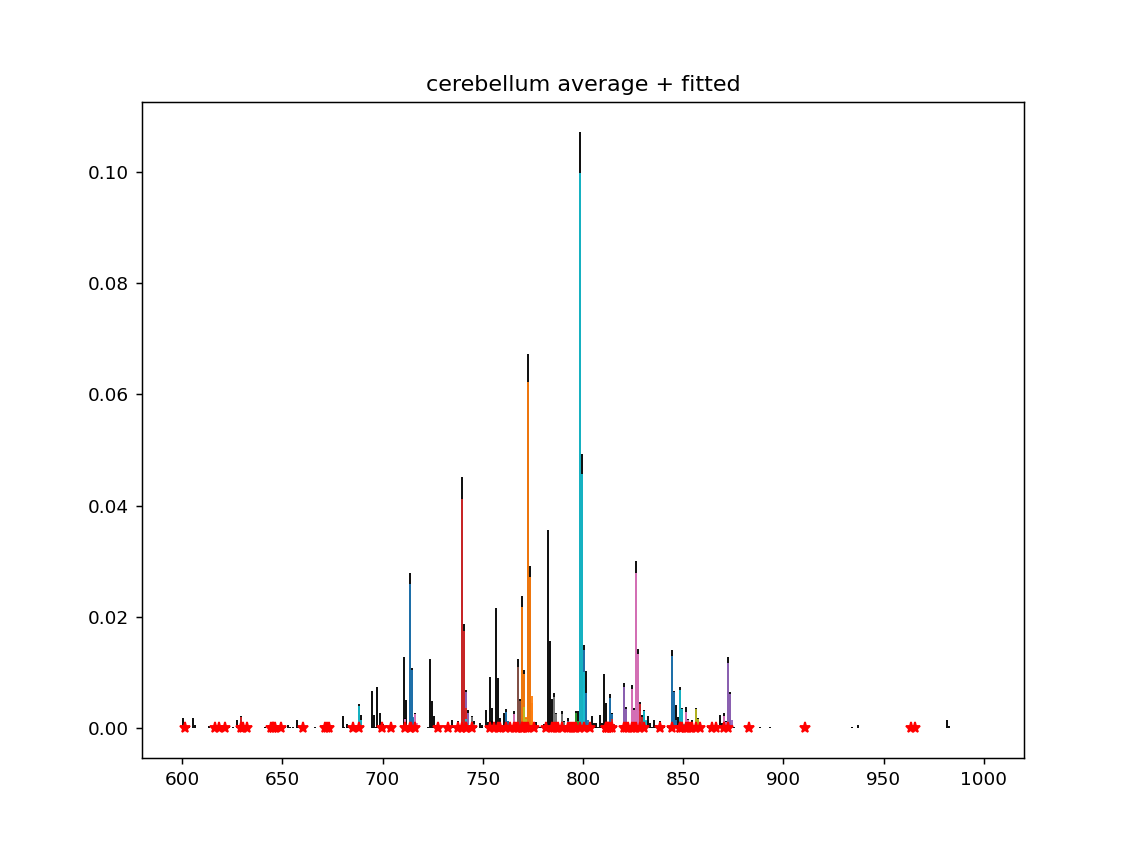

<IPython.core.display.Javascript object>


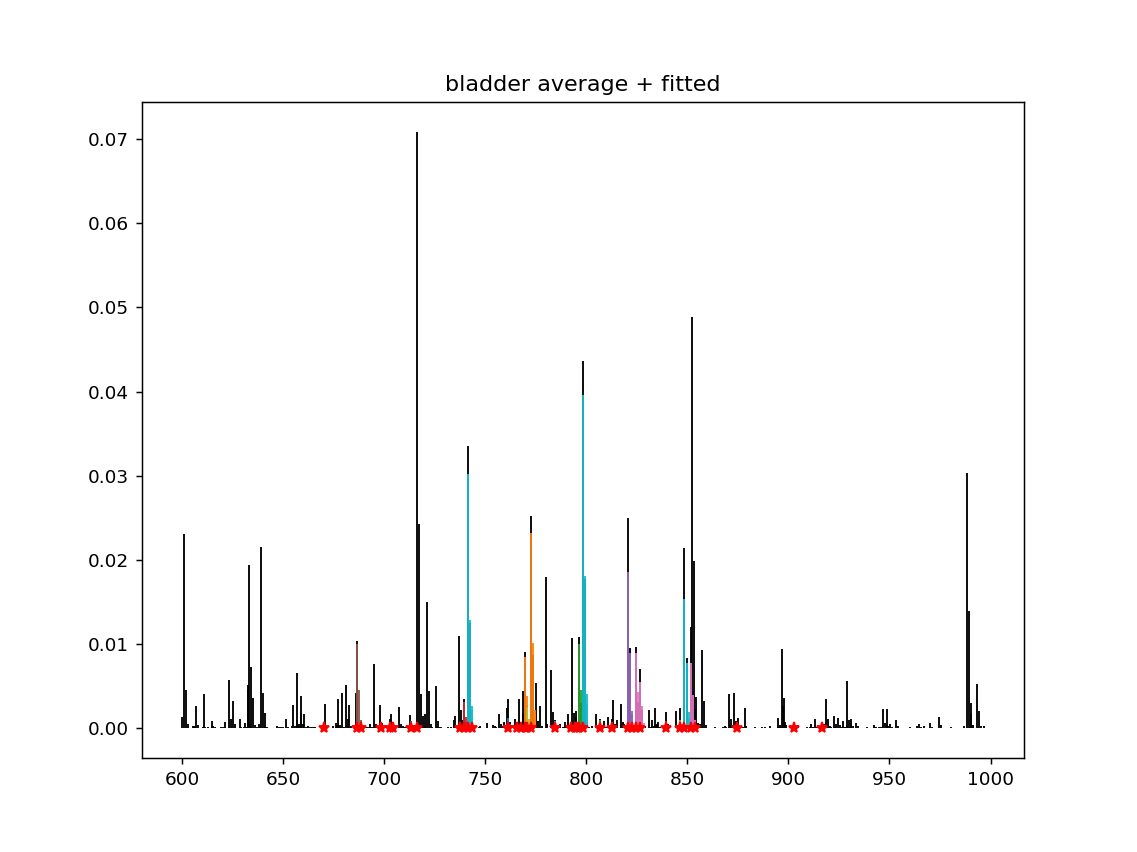

In [43]:
for i, n in enumerate(names):
    plt.figure()
    plt.title(n + ' average + fitted')
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_average[i]):
        if p > 1e-06*ppm_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.show()

## Whole-image Masserstein deconvolution

In [77]:
proportions_in_whole = [np.zeros(len(lipid_spectra)) for _ in range(2)]
analyzed_pixels = [0, 0]
control_lipid_images = [np.zeros(shp + (3, )) for shp in shapes]

for im_id, img in enumerate(images):
    print('Processing image:', names[im_id])
    s = time()
    for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        if rd.rand() >= 0.25:  # taking a given proportion of pixels 
            continue
        else:
            analyzed_pixels[im_id] += 1
        mz, intsy = img.getspectrum(idx)
        selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
        mz = mz[selected_range]
        intsy = intsy[selected_range]
#         selected_peaks = intsy >= 1e-4*max(intsy)
#         mz = mz[selected_peaks]
#         intsy = intsy[selected_peaks]
        pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
        pixel_spectrum.normalize()
        regression = estimate_proportions(pixel_spectrum, lipid_spectra, 
                                          MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1, progress=False)
        pr_array = np.array(regression['proportions'])
        proportions_in_whole[im_id] += pr_array
        control_lipid_images[im_id][ycoord-1, xcoord-1, ...] = pr_array[control_lipid_spectrum_ids]
    e = time()
    print('Regression time:', e-s)

Processing image: cerebellum
Processing pixel number 0
Regression time: 465.76895785331726
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 3041.718836784363


Display the regression results for the control lipids, compare with their single peak images:

In [78]:
profile_bladder_images = []
profile_cerebellum_images = []
for s_id in control_lipid_spectrum_ids:
    s = lipid_spectra[s_id]
    mz = s.confs[0][0]
    profile_cerebellum_images.append(profile_ion_image(cerebellum_profile_image, mz))
    profile_bladder_images.append(profile_ion_image(bladder_profile_image, mz))

<IPython.core.display.Javascript object>


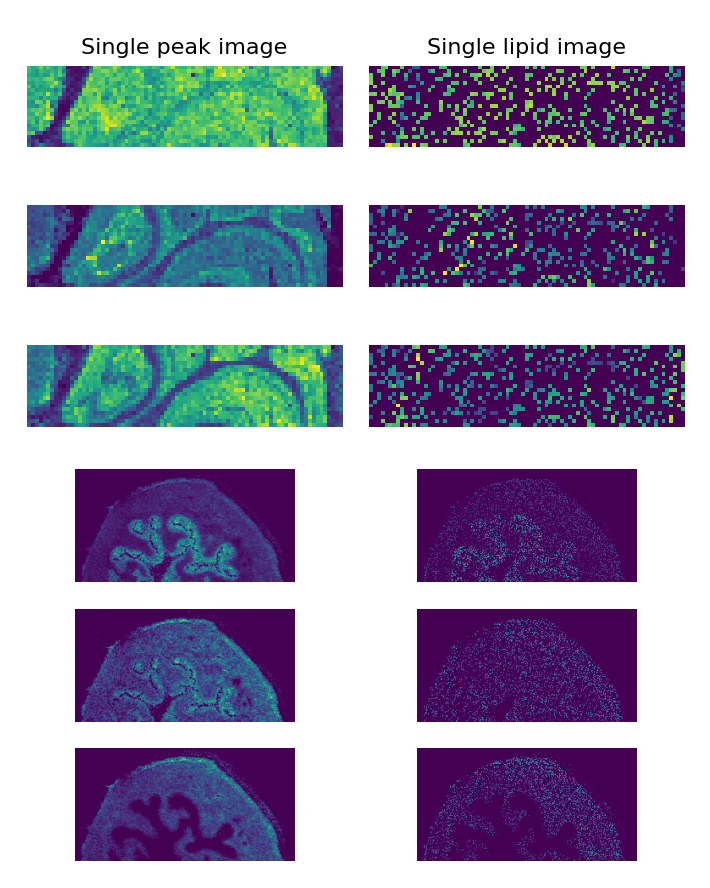

In [79]:
plt.figure(figsize=(4, 5))
plt.subplot(6, 2, 1)
plt.title('Single peak image')
plt.subplot(6, 2, 2)
plt.title('Single lipid image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(6, 2, 1+2*i)
    plt.imshow(profile_cerebellum_images[i])
    plt.axis('off')
    plt.subplot(6, 2, 2+2*i)
    plt.imshow(control_lipid_images[0][..., i])
    plt.axis('off')
for i, n in enumerate(control_lipid_names):
    plt.subplot(6, 2, 7+2*i)
    plt.imshow(profile_bladder_images[i])
    plt.axis('off')
    plt.subplot(6, 2, 8+2*i)
    plt.imshow(control_lipid_images[1][..., i])
    plt.axis('off')
plt.tight_layout()

In [80]:
for i, s in enumerate(shapes):
    proportions_in_whole[i] /= analyzed_pixels[i]

<IPython.core.display.Javascript object>


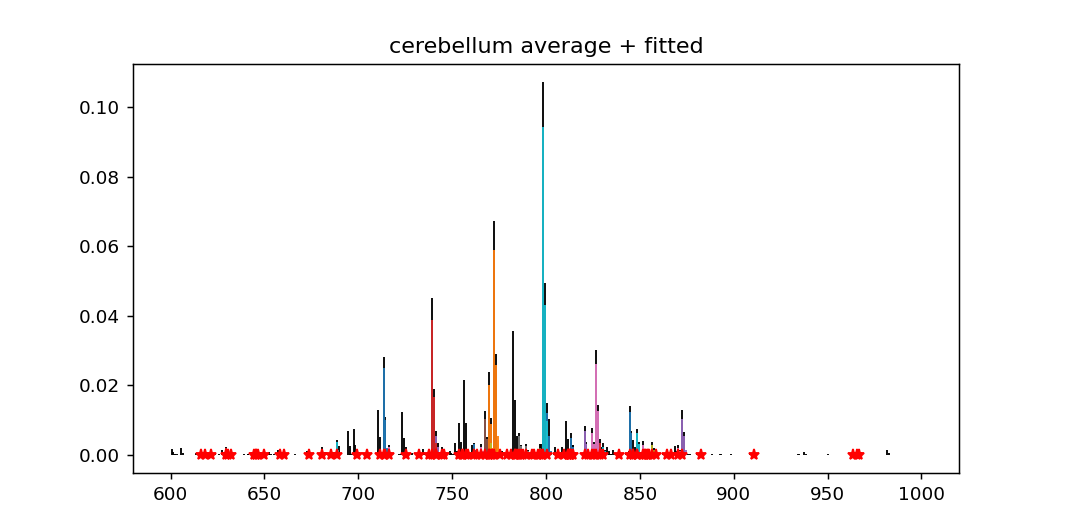

<IPython.core.display.Javascript object>


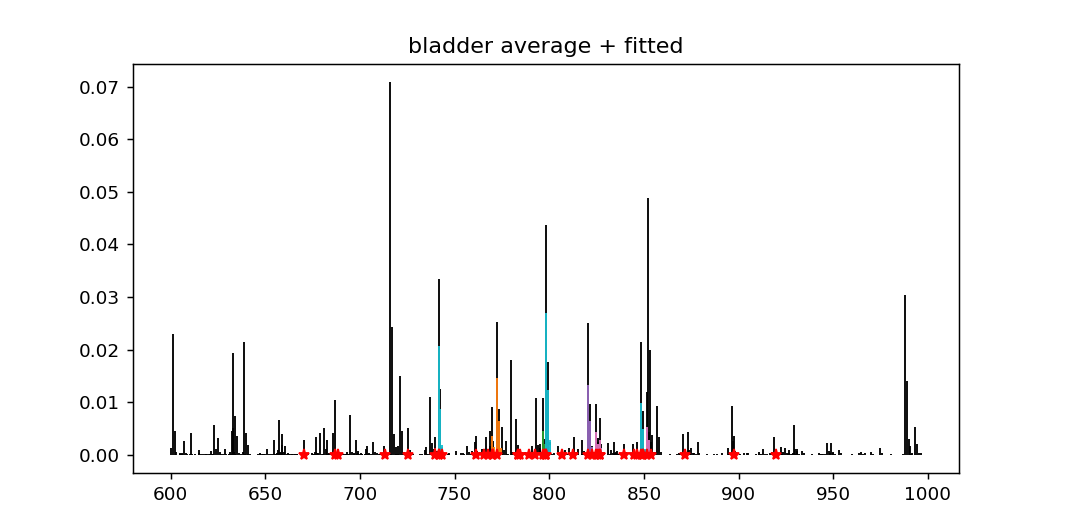

In [81]:
for i, n in enumerate(names):
    plt.figure(figsize=(6,3))
    plt.title(n + ' average + fitted')
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
        if p > 1e-06*ppm_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.show()

Save the annotation results:

In [82]:
for i,n in enumerate(names):
    with open(n + '_annotation_results.tsv', 'w') as h:
        h.write('\t'.join(['Formula     ', 'Mass', 'Concentration']) + '\n')
        for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
            if p > 1e-06*ppm_threshold:
                h.write('\t'.join([s.formula, str(round(s.confs[0][0], 4)), str(round(p, 4))]) + '\n')

## Comparing annotations

The overall correlation between the results of the two annotation strategies:

<IPython.core.display.Javascript object>


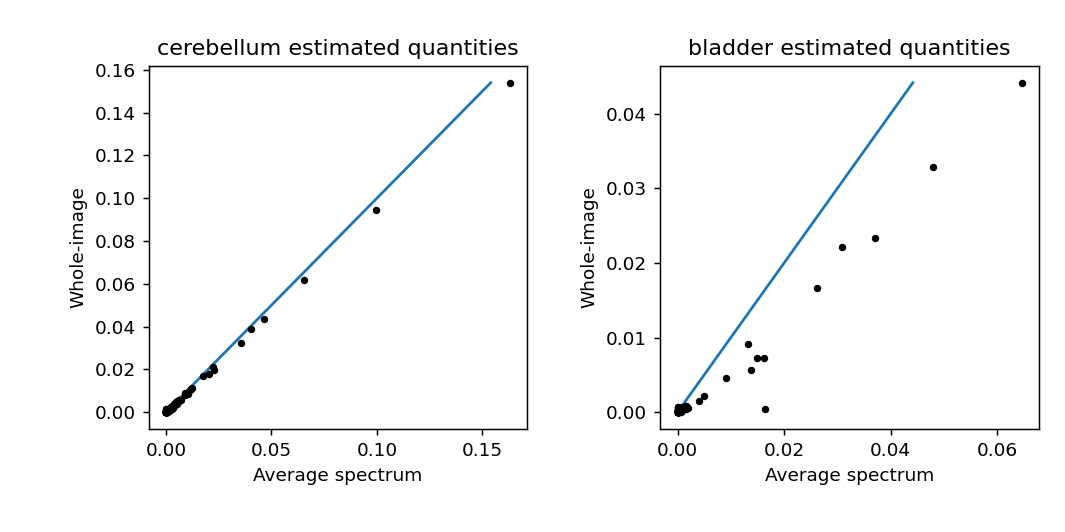

In [83]:
plt.figure(figsize=(6,3))
for i, n in enumerate(names):
    plt.subplot(121+i)
    plt.title(n + ' estimated quantities')
    plt.plot([0, max(proportions_in_whole[i])], [0, max(proportions_in_whole[i])])
    plt.plot(proportions_in_average[i], proportions_in_whole[i], 'k.')
    
    plt.ylabel('Whole-image')
    plt.xlabel('Average spectrum')
plt.tight_layout()

In [84]:
for i, n in enumerate(names):
    print('Correlation of estimations in', n, np.corrcoef(proportions_in_average[i], proportions_in_whole[i])[0,1])

Correlation of estimations in cerebellum 0.9997146924142624
Correlation of estimations in bladder 0.9832762717164432


In [85]:
formulas_in_average = [set([s.formula for s, p in zip(lipid_spectra, proportions_in_average[i]) if p >= 1e-06*ppm_threshold]) for i in range(2)]
formulas_in_whole = [set([s.formula for s, p in zip(lipid_spectra, proportions_in_whole[i]) if p >= 1e-06*ppm_threshold]) for i in range(2)]
venn_dicts = [{'average, then annotate': formulas_in_average[i], 'annotate, then average': formulas_in_whole[i]} for i in range(2)]

cerebellum


<IPython.core.display.Javascript object>


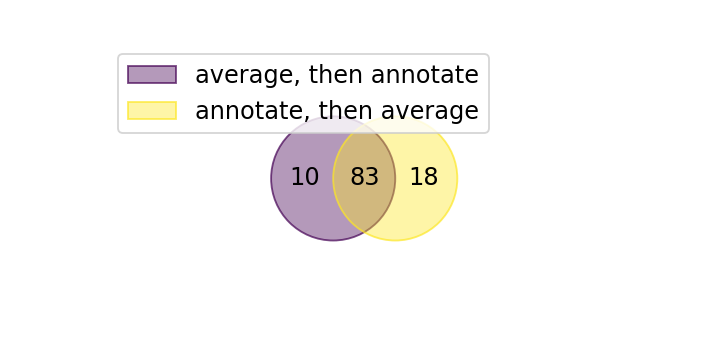

bladder


<IPython.core.display.Javascript object>


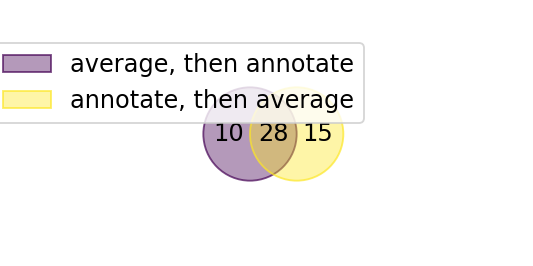

In [86]:
print(names[0])
venn(venn_dicts[0], figsize=(4,2))
plt.show()
print(names[1])
venn(venn_dicts[1], figsize=(4,2))
plt.show()

Examples of lipids found only when the image was annotated on a per-pixel basis ("annotate -> average" rather than "average -> annotate")

In [87]:
found_only_per_pixel = [sorted([(p, i) for i,p in enumerate(proportions_in_whole[j]) if proportions_in_average[j][i] <=0.0001], reverse=True) for j in range(2)]

In [88]:
found_only_per_pixel[0][:10]

[(0.0013180507678507403, 275),
 (0.0012639630891440766, 1149),
 (0.0007038578777381242, 1530),
 (0.0006596902946784827, 459),
 (0.0006299790094073388, 261),
 (0.0005516022539586839, 1566),
 (0.0004446072402998234, 1588),
 (0.000305626772872864, 110),
 (0.00024920674387931315, 2029),
 (0.0002467081734239652, 2056)]

In [89]:
to_check_bladder = 136
spectrum_hidden_in_bladder = lipid_spectra[to_check_bladder]
spectrum_hidden_in_bladder.confs[0][0]

667.37411242167

In [90]:
hidden_mass_in_bladder = 849.625
closest_average_peak_in_bladder = 849.56

In [91]:
to_check_cerebellum = 1144
weird = lipid_spectra[to_check_cerebellum]
weird.confs[0][0]

712.359190634

In [96]:
hidden_mass_in_cerebellum = 846.542
closest_average_peak_in_cerebellum = 846.532

In [97]:
# hidden_mass_in_cerebellum = 745.478
# closest_average_peak_in_cerebellum = 745.495  # not from average, but from another lipid

<IPython.core.display.Javascript object>


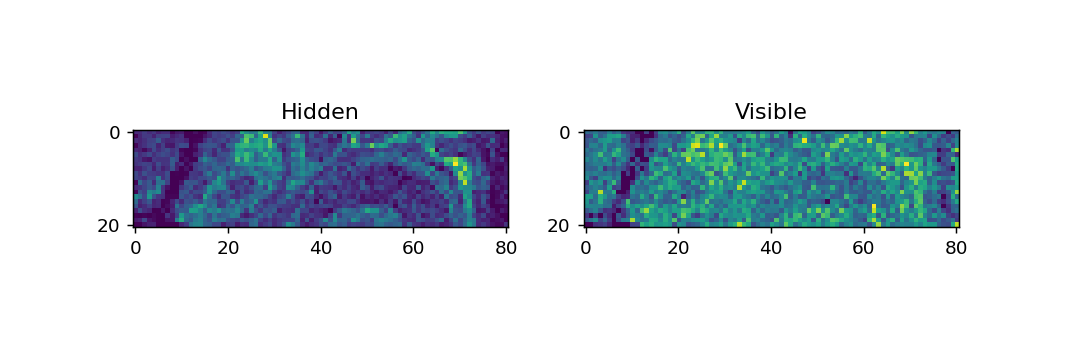

Text(0.5, 1.0, 'Visible')

In [98]:
hidden_image = profile_ion_image(cerebellum_profile_image, hidden_mass_in_cerebellum)
closest_image = profile_ion_image(cerebellum_profile_image, closest_average_peak_in_cerebellum)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden')
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Visible')

<IPython.core.display.Javascript object>


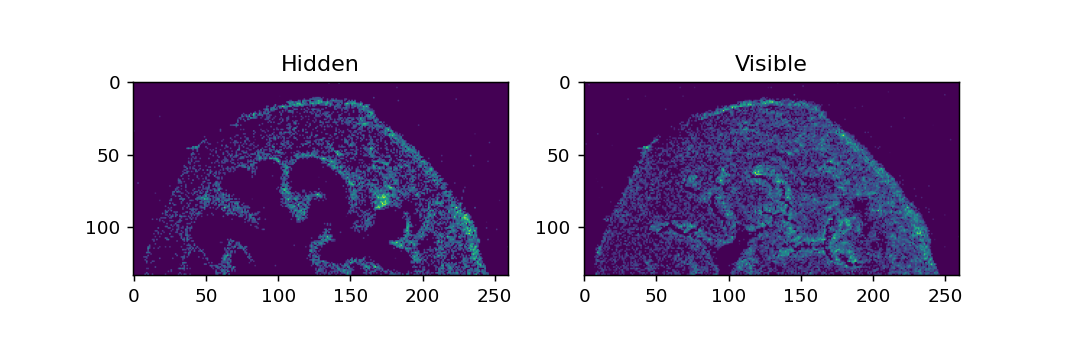

Text(0.5, 1.0, 'Visible')

In [95]:
hidden_image = profile_ion_image(bladder_profile_image, hidden_mass_in_bladder)
closest_image = profile_ion_image(bladder_profile_image, closest_average_peak_in_bladder)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden')
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Visible')

Notka: Obrazki po dekonwolucji nie musza byc ladne, interesuje nas jedynie istnienie ukrytych pikow 

Po segmentacji zrobic porownanie widm w segmentach odpowiadajacych hidden pikom oraz widm srednich